# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Задача: построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.shape

(7591, 2)

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<AxesSubplot:>

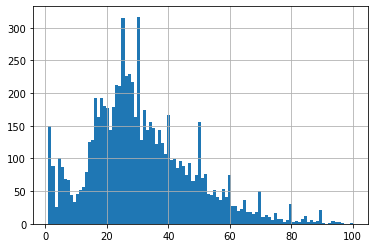

In [7]:
df['real_age'].hist(bins=100)

In [8]:
df[df['real_age']<10].count()

file_name    663
real_age     663
dtype: int64

In [9]:
%%time
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 586 ms, sys: 383 ms, total: 969 ms
Wall time: 1min 24s


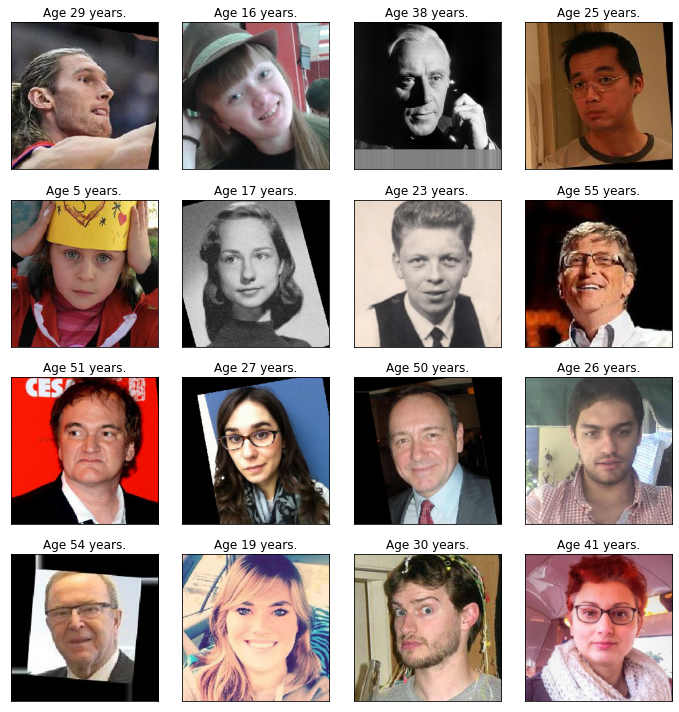

In [17]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age '+ str(target[i]) + ' years.')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по исследовательскому анализу
Видим, что у нас нет картинок с возрастом 0 лет.\
Есть всплеск с картинками с возрастом до 10 лет.\
Средний возраст 31 год.
А максимальный - 100 лет.
Следовательно можно использовать другой тип данных для возраста - int8.

Визуально можно сказать, что целевой признак (возраст) соответсвует изображениям.

Всего 7591 изображений в датасете, это не много если судить по предидущим работам. 
Именование изображений предполагает использование 6 разрядов.

В нашем датасете относительно мало лиц подростков и стариков. 
Много лиц от 17 до 25 лет.
Достаточно младенцев одного и двух лет.

Это может повлиять на точность распознавания разных возрастных групп. 
Лучше, чтобы данных было больше.

## Обучение модели

### Код

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.,
                                       horizontal_flip=True,
                                       # vertical_flip=True,
                                       # rotation_range=90,
                                       # width_shift_range=0.2,
                                       # height_shift_range=0.2
                                       )

    train_data = datagen.flow_from_dataframe(
            dataframe=df,
            directory=path+'/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345,
            subset='training')

    return train_data

def load_test(path):

    df = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

    test_data = datagen.flow_from_dataframe(
            dataframe=df,
            directory=path+'/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345,
            subset='validation')

    return test_data

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=9,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs, batch_size=batch_size)

    return model


```

### Результат вывода на экран

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

2022-10-24 14:15:32.349232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-10-24 14:15:32.350937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-10-24 14:15:33.217685: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-24 14:15:33.229243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-24 14:15:33.229329: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 14:15:33.229362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 14:15:33.231409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-24 14:15:33.231801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-24 14:15:33.233770: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-24 14:15:33.234922: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-24 14:15:33.234988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-24 14:15:33.239048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-10-24 14:15:33.413301: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-24 14:15:33.419984: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-10-24 14:15:33.420587: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f2afd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-24 14:15:33.420612: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-24 14:15:33.570213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x458b130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-24 14:15:33.570253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-24 14:15:33.572287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-24 14:15:33.572343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 14:15:33.572353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 14:15:33.572380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-24 14:15:33.572390: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-24 14:15:33.572399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-24 14:15:33.572408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-24 14:15:33.572417: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-24 14:15:33.576165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-10-24 14:15:33.576223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 14:15:33.956635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-24 14:15:33.956689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-10-24 14:15:33.956697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-10-24 14:15:33.960639: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-24 14:15:33.960693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/9
2022-10-24 14:15:44.795751: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 14:15:45.263612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 63s - loss: 249.7551 - mae: 11.1443 - val_loss: 756.5224 - val_mae: 22.5783
Epoch 2/9
178/178 - 48s - loss: 80.1862 - mae: 6.7425 - val_loss: 658.1734 - val_mae: 20.5488
Epoch 3/9
178/178 - 49s - loss: 52.6263 - mae: 5.5383 - val_loss: 400.3408 - val_mae: 14.7387
Epoch 4/9
178/178 - 49s - loss: 35.7952 - mae: 4.5483 - val_loss: 135.1491 - val_mae: 8.8008
Epoch 5/9
178/178 - 50s - loss: 26.6902 - mae: 3.9680 - val_loss: 80.6174 - val_mae: 6.8290
Epoch 6/9
178/178 - 50s - loss: 20.8108 - mae: 3.5065 - val_loss: 69.3639 - val_mae: 6.1657
Epoch 7/9
178/178 - 51s - loss: 17.5344 - mae: 3.1756 - val_loss: 69.8825 - val_mae: 6.4341
Epoch 8/9
178/178 - 51s - loss: 13.4696 - mae: 2.8244 - val_loss: 63.0916 - val_mae: 5.9284
Epoch 9/9
178/178 - 51s - loss: 11.4366 - mae: 2.5713 - val_loss: 64.9294 - val_mae: 6.0983
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 64.9294 - mae: 6.0983
Test MAE: 6.0983

```

## Анализ обученной модели

### Вывод

Провели исследовательский анализ данных, посмотрели на распределение, возможно предсказания возраста в районе 10 лет и старше 80 будет не таким точным, так как в нашей выборке довольно мало лиц с таким возрастом относительно всего датасета.

Что помогло достичь целевой метрики: 
- Был выбран минимальный шаг для Adam,
- Была применена аугментация - отражение по горизонтали

Если говорить о MAE в 6 лет, то можно сделать слудующие выводы по нашим бизнес-задачам:
1. Можно попытаться выяснить какие возрастные группы интересуют заказчика, если это допустим 3 группы: дети, старики и все остальные, то можно попробовать переделать проект в задачу классификации потому что диапазон возраста для этих групп (условно) будет 20-30 лет, но даже так при MAE в 6 лет этого не достаточно, чтобы не ошибаться слишком сильно. Если возрастных групп будет уже 6, то смысла пытаться внедрить такой способ классификации ещё меньше, ведь группа "подростки" может быть от 17 до 21 года - это 5 лет, а MAE 6 лет. Считаю что для классификации подходит очень условно с большими оговорками.

2. Контролировать добросовестность кассиров при продаже алкоголя точно нельзя. Будет много ложных срабатываний, как и ложно-совершеннолетних, так и ложно-несовершеннолетних. Здесь для бизнеса два риска: репутационные убытки(потеря клиента) и риск привлечения к ответсвенности. Можно дополнительно посчитать стоимость одной ошибки, в одних странах штраф для бизнеса, в других более серьёзная ответсвенность.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы